In [10]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
import matplotlib as mpl
from numba import njit

import cmocean

from scipy.integrate import romberg, quad

time_conv = 977.79222167

In [2]:
from numba import njit

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos
# print(plot_pos)

In [3]:
sim_list = ['phantom-vacuum-Sg20-Rc4.0']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
sn = read_snap(100, 0, fields=None)

In [27]:
center = np.array([200, 200, 200])
pos = sn.part0.pos - center
dens = sn.part0.rho.value
SFR = sn.part0.sfr.value
vel = sn.part0.vel.value

tree = cKDTree(pos)

In [28]:
nres = 1024
x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)

nres_low = 128
x, y = np.meshgrid(np.linspace(-15, 15, nres_low), np.linspace(-15, 15, nres_low), indexing='ij')
plot_pos_lowres = create_plot_pos(x, y, nres_low)

_, key = tree.query(plot_pos)
_, key_lowres = tree.query(plot_pos_lowres)

In [29]:
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

plot_SFR = SFR[key]
plot_SFR_map = np.reshape(plot_SFR, (nres, nres))

plot_vel = vel[key_lowres]
plot_vel_map = np.reshape(plot_vel, (nres_low, nres_low, 3))

A Jupyter Widget

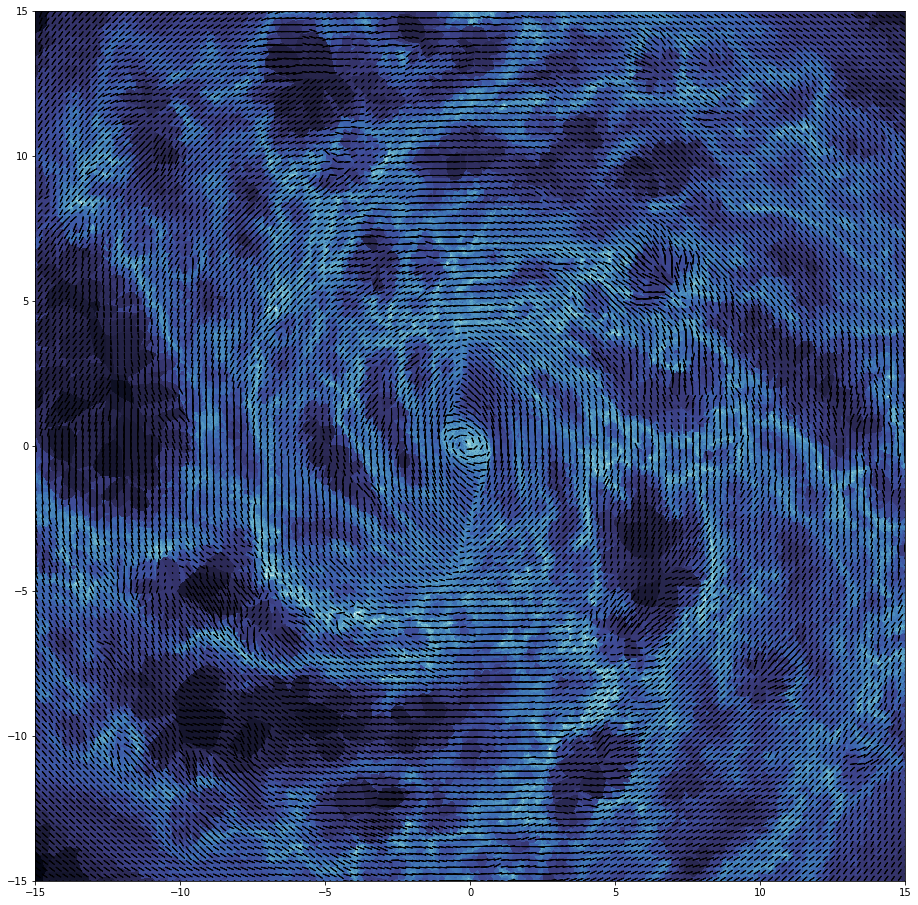

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap=cmocean.cm.ice)
for pt,pt_vel in tqdm(zip(plot_pos_lowres, plot_vel)):
    ax.arrow(pt[0], pt[1], pt_vel[0]/1000, pt_vel[1]/1000)
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)
plt.show()

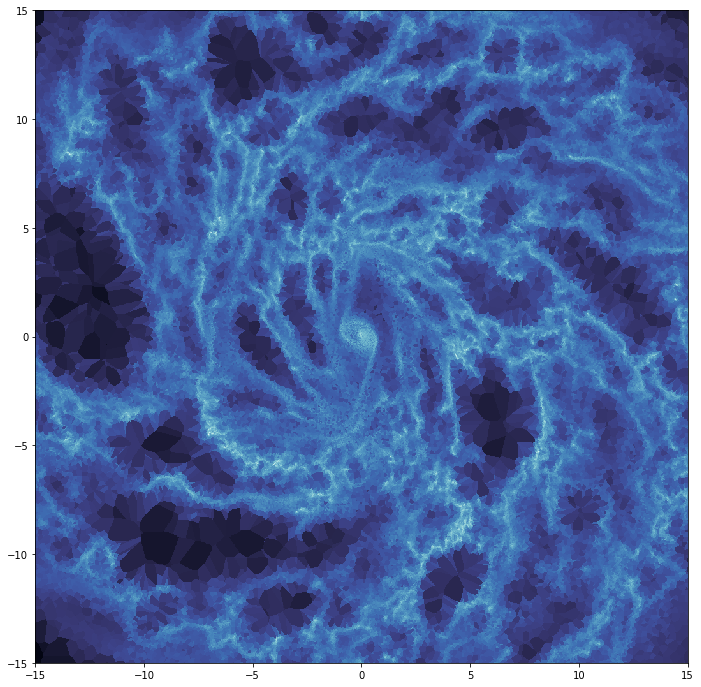

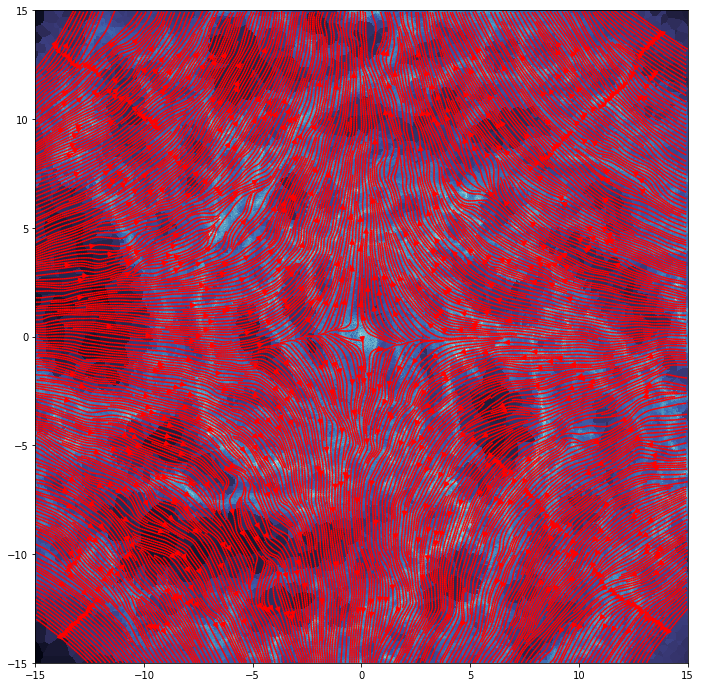

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
extent = [-15, 15, -15, 15]
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap=cmocean.cm.ice)
ax.streamplot(np.linspace(-15, 15, nres_low), np.linspace(-15, 15, nres_low), plot_vel_map[:,:,0], plot_vel_map[:,:,1], 
              color='r', density=10)
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)
plt.show()